# Data block API foundations

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import torch
from torch import *

#let me be on my mac
def cuda(self, device=None, non_blocking=False) : return self
torch.Tensor.cuda = cuda

In [3]:
import torch.nn.functional as F

In [4]:
from lib.model import *
from lib.modelmanager import *
from lib.callbacks import *
from lib.data import *
from lib.optimizers import *
from lib.datasets import *
from lib.utilities import *
from lib.imagenette import *
from lib.graphics import *
from pathlib import Path

### download imagenette data

Let's use the [imagenette dataset](https://github.com/fastai/imagenette/blob/master/README.md) and build the data blocks we need along the way.

In [5]:
path = untar_data(URLs.IMAGENETTE_160)
print(f"url:{URLs.IMAGENETTE_160}")
print(f"local path:{path}")

url:https://s3.amazonaws.com/fast-ai-imageclas/imagenette-160
local path:/Users/kasparlund/.fastai/data/imagenette-160


/Users/kasparlund/.fastai/data/imagenette-160
13394
/Users/kasparlund/.fastai/data/imagenette-160/train/n03394916/n03394916_58454.JPEG


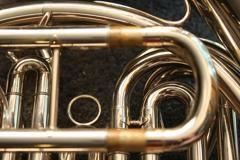

In [6]:
files = FileList.get_files(path, image_extensions, recurse=True)
img   = PIL.Image.open(files[0])
print(len(files))
print(files[0])
img

In [7]:
import numpy
imga = numpy.array(img)
print(imga.shape)
imga[:10,:10,0]

(160, 240, 3)


array([[ 85,  80,  74,  69,  68,  67,  66,  65,  59,  54],
       [ 83,  79,  73,  69,  68,  67,  65,  64,  61,  59],
       [ 84,  81,  76,  72,  70,  68,  65,  62,  64,  65],
       [ 81,  78,  75,  71,  70,  67,  64,  60,  54,  55],
       [ 66,  64,  64,  63,  65,  64,  64,  61,  63,  62],
       [ 62,  60,  61,  63,  68,  71,  74,  73,  81,  77],
       [ 74,  71,  70,  71,  75,  79,  82,  82,  75,  75],
       [ 83,  79,  75,  73,  74,  76,  77,  77,  77,  86],
       [ 64,  79,  93,  93,  87,  89, 106, 123, 157, 179],
       [ 77, 105, 145, 176, 197, 217, 240, 255, 252, 255]], dtype=uint8)

### Read files and split them in train and validation sets

In [8]:
#get files from path and include a transform tfms that makes basic preprocessing as we get the images
tfms   = [make_rgb, ResizeFixed(128), PilRandomDihedral(), to_byte_tensor, to_float_tensor]
images = ImageList.from_files(path, tfms=tfms)

#split data based on the foldername of the grandparent
data = images.split(split_condition=partial(grandparent_splitter, valid_name='val') ); 

#The label is the name of the parent folder. The CategoryProcessor tokenizes the labels
data.label_data(parent_labeler, proc_y=CategoryProcessor())
#print(type(data.train))
#print(data.train)

/Users/kasparlund/.fastai/data/imagenette-160


x.shape:torch.Size([3, 128, 128])
x:
tensor([[[0.3490, 0.3373, 0.3216,  ..., 0.3451, 0.3490, 0.3647],
         [0.3216, 0.3098, 0.2941,  ..., 0.4902, 0.4510, 0.4314],
         [0.2863, 0.2706, 0.2549,  ..., 0.3451, 0.3373, 0.3333],
         ...,
         [0.2667, 0.2706, 0.2706,  ..., 0.7529, 0.7882, 0.8353],
         [0.2863, 0.2863, 0.2902,  ..., 0.4157, 0.4510, 0.4824],
         [0.3216, 0.3176, 0.3137,  ..., 0.1804, 0.1961, 0.2118]],

        [[0.2863, 0.2745, 0.2588,  ..., 0.2980, 0.3020, 0.3176],
         [0.2588, 0.2471, 0.2314,  ..., 0.4392, 0.3961, 0.3765],
         [0.2235, 0.2118, 0.2039,  ..., 0.2824, 0.2706, 0.2667],
         ...,
         [0.2275, 0.2196, 0.2157,  ..., 0.6863, 0.7216, 0.7608],
         [0.2471, 0.2392, 0.2353,  ..., 0.3765, 0.4078, 0.4353],
         [0.2824, 0.2667, 0.2549,  ..., 0.1608, 0.1725, 0.1843]],

        [[0.2235, 0.2118, 0.1961,  ..., 0.2588, 0.2549, 0.2706],
         [0.1961, 0.1843, 0.1686,  ..., 0.3804, 0.3412, 0.3176],
         [0.1608, 0.1

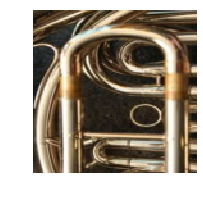

In [9]:
x,y = data.train[0]
print(f"x.shape:{x.shape}\nx:\n{x}\ny:{y}") 
show_image(x)

## Train Imagenette

In [10]:
bs=128
databunch = DataBunch( data.get_train_dataLoader(batch_size=bs,   num_workers=4, shuffle=True), 
                       data.get_valid_dataLoader(batch_size=bs*2, num_workers=4), 
                       c_in=3, c_out=max(data.train.y)+1 )
print(len(databunch.train_dl))

101


In [11]:
layers_sizes = [32,64,128,256,512]

sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 
cbfs_base = [TrainableModelCallback, TrainEvalCallback, OptimizerCallback, 
#        partial(ParamScheduler, 'lr', sched),
        partial(BatchTransformXCallback, norm_imagenette),
#        partial(MixUp,α=0.4),
        
        #CudaCallback,
        ProgressCallback,
       ]
cbfs = cbfs_base.copy() + [Recorder, partial(AvgStatsCallback,[accuracy])]
cbfs_lr_Finder = cbfs_base.copy() + [LR_Finder]

In [12]:
layer = partial(conv_layer, stride=2, bn=False, zero_bn=False, act=GeneralRelu )
mm    = CnnModelManager( get_cnn_model(layers_sizes, databunch.c_in, databunch.c_out, layer) )
mm.initialize(is_resnet=False)

learn = Learner( mm.model, databunch, loss_func=F.cross_entropy)
%time learn.fit(1, opt=Adam(sched,max_lr=2e-4, moms=(0.85,0.95), max_wd = 1e-6), cb_funcs=cbfs)

CPU times: user 5min 17s, sys: 1min 2s, total: 6min 20s
Wall time: 1min 14s


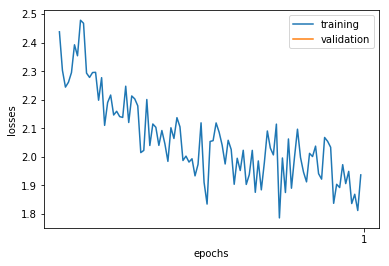

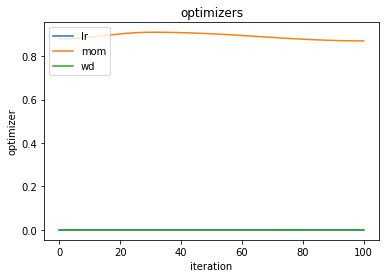

In [13]:
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr()

The [leaderboard](https://github.com/fastai/imagenette/blob/master/README.md) as this notebook is written has ~85% accuracy for 5 epochs at 128px size, so we're definitely on the right track!

In [14]:
xb,_ = mm.getFirstbatch( databunch, norm_imagenette)
mm.summary(xb, only_leaves=True, print_mod=True)


Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
torch.Size([128, 32, 64, 64])

GeneralRelu()
torch.Size([128, 32, 64, 64])

Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
torch.Size([128, 64, 32, 32])

GeneralRelu()
torch.Size([128, 64, 32, 32])

Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
torch.Size([128, 128, 16, 16])

GeneralRelu()
torch.Size([128, 128, 16, 16])

Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
torch.Size([128, 256, 8, 8])

GeneralRelu()
torch.Size([128, 256, 8, 8])

Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
torch.Size([128, 512, 4, 4])

GeneralRelu()
torch.Size([128, 512, 4, 4])

AdaptiveAvgPool2d(output_size=1)
torch.Size([128, 512, 1, 1])

Lambda()
torch.Size([128, 512])

Linear(in_features=512, out_features=10, bias=True)
torch.Size([128, 10])
